# DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import timeit
import matplotlib.colors

In [2]:
df_engagement = pd.read_pickle('df_engagement_scaled.pkl')
df_consume = pd.read_pickle('df_consume_scaled.pkl')

## How does DBSCAN behave with different radius?

In [3]:
def dbscan(df, radius=0.1, min_points=5):
    """
    Using DBSCAN method, returns:
    - number of outliers/noise
    - the number of clusters
    - core points
    """
    db = DBSCAN(eps=radius, min_samples=min_points).fit(df)
    labels = db.labels_
    number_outliers=np.count_nonzero(labels==-1)
    number_clusters=len(set(labels))-(1 if -1 in labels else 0)
    core_points=len(db.core_sample_indices_)
    return number_outliers, number_clusters, core_points, labels

## How to define the optimum radius?

In [4]:
def dbscan_radius_loop(df, start, end, step):
    """
    Makes a loop over all radius on an interval from 0.001 to 0.1
    returns the following arrays:
    - radius
    - number of clusters
    - number of outliers
    - number of core points
    """
    start = timeit.default_timer()
    radius=[]
    number_clusters=[]
    number_outliers=[]
    number_core_points=[]
    x=[(i/100) for i in range(100,151)]
    for i in x:
        outliers, clusters, core= dbscan(df, radius=i)
        number_outliers.append(outliers)
        number_clusters.append(clusters)
        number_core_points.append(core)
    stop = timeit.default_timer()
    print('Running Time: %.2f'% (stop-start))
    return x, number_clusters, number_outliers, number_core_points

### Test with both groups of variables

In [6]:
number_outliers, number_clusters, core_points, labels = dbscan(df_engagement, radius=1.3, min_points=30)

In [300]:
x, number_outliers_consume, number_clusters_consume, number_core_points_consume=dbscan_radius_loop(df_consume)

## Find Optimal Minimum Number of Points

In [7]:
def k_neighbors_plot(df, variable_group):
    min_k=5
    max_k=35
    cmap = plt.get_cmap("viridis", max_k)
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    for i in range(min_k,max_k,5):
        ns = i
        nbrs = NearestNeighbors(n_neighbors=ns).fit(df)
        distances, indices = nbrs.kneighbors(df)
        distanceDec = sorted(distances[:,ns-1], reverse=False)
        ax.plot(list(range(1, (len(distanceDec)+1))), distanceDec, label='%d'%i, color=cmap(i))
        ax.set_ylim([0,2])
        ax.set_title('KNN Distance for %s'%variable_group, fontsize=14)
        ax.set_ylabel('k-distance', fontsize=12)
        ax.set_xlabel('Point Label', fontsize=12)
        ax.legend()
        ax.grid(linestyle='dashed')
    plt.savefig('knn_distance_%s'%variable_group)

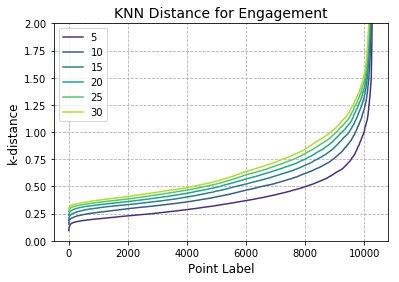

In [8]:
k_neighbors_plot(df_engagement, 'Engagement')

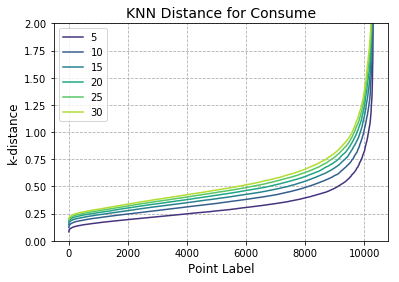

In [9]:
k_neighbors_plot(df_consume, 'Consume')

## Find Optimal Radius:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


distance:  0.0995658938199194


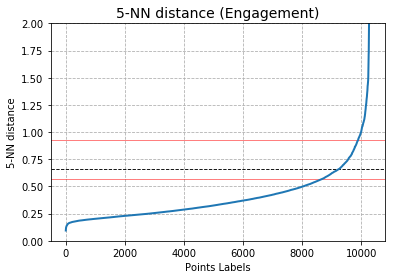

In [18]:
#best_radius=radius_derivative(define_radius(df_engagement, 5,0.1, 0.1, 0.1, 'Engagement'))
distances=define_radius(df_engagement, 5, 0.57, 0.93, 0.66, 'Engagement')
#distances=define_radius(df_consume, 5, 0.58, 0.87, 0.69, 'Consume')
threshold=0
for x1,y2 in enumerate(distances[1::2]):
    y1=distances[x1*2]
    if (y2-y1!=0):
        upper_bound=y2-y1
        break
y=upper_bound
i=1
while threshold==0:
    if y*i>1:
        threshold=1/i
    i*=10

for x1,y2 in enumerate(distances[1::2]):
    dy1=0
    y1=distances[x1*2]
    dy2=y2-y1
    if ((y1>threshold) & (dy2/dy1>10) & (y2-y1>(threshold*2))):
        break
    dy1=dy2
print('distance: ',distances[x1*2+1])
plt.savefig('knn_consume')

In [11]:
def define_radius(df, k, y1, y2, y3, variable_group):
    ns = k
    nbrs = NearestNeighbors(n_neighbors=ns).fit(df)
    distances, indices = nbrs.kneighbors(df)
    distanceDec = sorted(distances[:,ns-1], reverse=False)
    
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    ax.axhline(y=y1, linewidth=0.5, color='r')
    ax.axhline(y=y2, linewidth=0.5, color='r')
    ax.axhline(y=y3, linewidth=0.9, color='black', linestyle='dashed')
    ax.set_ylim([0,2])
    ax.plot(list(range(1, (len(distanceDec)+1))), distanceDec, linewidth=2)
    ax.grid(linestyle='dashed')
    ax.set_title('%d-NN distance (%s)'%(k,variable_group), fontsize=14)
    ax.set_ylabel('%d-NN distance'%k)
    ax.set_xlabel('Points Labels')
    plt.savefig('k_radius_%s'%variable_group)
    return distanceDec

In [24]:
#0.93
number_outliers, number_clusters, core_points, labels_consume = dbscan(df_consume, radius=0.87, min_points=5)
number_outliers, number_clusters, core_points

(149, 5, 10036)

In [34]:
#0.93
number_outliers, number_clusters, core_points, labels_engagement = dbscan(df_engagement, radius=.98, min_points=5)
number_outliers, number_clusters, core_points

(190, 6, 9964)

## Define Final Clusters:

In [35]:
df_dbscan=pd.concat([df_engagement, df_consume], axis=1)
df_dbscan.insert(df_dbscan.shape[1], 'labels_engagement', labels_engagement)
df_dbscan.insert(df_dbscan.shape[1], 'labels_consume', labels_consume)

k=0
df_dbscan['labels']=''
for i in list(df_dbscan.loc[:,'labels_engagement'].unique()):
    for j in list(df_dbscan.loc[:,'labels_consume'].unique()):
        mask1=df_dbscan['labels_engagement']==i
        mask2=df_dbscan['labels_consume']==j
        df_dbscan['labels'][mask1 & mask2]=k
        k+=1

mask1_outliers=df_dbscan['labels_engagement']==-1
mask2_outliers=df_dbscan['labels_consume']==-1
#df_dbscan['labels'][mask1_outliers]=df_dbscan['labels_consume']
#df_dbscan['labels'][mask2_outliers]=df_dbscan['labels_engagement']
df_dbscan['labels'][mask1_outliers]=-1
df_dbscan['labels'][mask2_outliers]=-1
df_dbscan['labels'].unique()

labels=df_dbscan['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))
sum_count=0
for i,j in enumerate(labels):
    counts=df_dbscan[df_dbscan['labels']==j]
    if (len(counts)>100):
        print(j, len(counts))
    sum_count+=len(counts)
    
df_plot=df_dbscan.copy()
df_plot.set_index('labels')
for i,j in enumerate(labels):
    sum_label=(df_plot['labels']==j).sum()
    if sum_label<100:
        df_plot=df_plot.drop(df_plot[df_plot['labels']==j].index)

labels=df_plot['labels'].unique()
#labels=labels[labels!=-1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NUMBER OF CLUSTERS: 15
0 8148
6 1108
12 670
-1 325


### you kept:
* education
* engagement
* premium_house
* premium_motor

In [1178]:
df_engagement=df_engagement.drop('claims_rate', axis=1)

In [38]:
def plot_clusters(var1, var2, i1, i2, var1_name, var2_name, save_as):
    fig=plt.figure(figsize=(10,4))
    ax=plt.subplot2grid((1,2), (0,0))
    #ax2=plt.subplot2grid((1,2), (0,1))
    
    cmap = plt.get_cmap("viridis", len(labels))
    
    for i,j in enumerate(labels):
        if i<(len(labels)-1):
            ax.scatter(df_dbscan.loc[:,var1][df_dbscan['labels']==j],
                   df_dbscan.loc[:,var2][df_dbscan['labels']==j], label='C%d'%(i+1), color=cmap(i),
                       edgecolor='black', linewidth=0.1)
        #if ((i==i1)|(i==i2)):
        #    ax2.scatter(df_dbscan.loc[:,var1][df_dbscan['labels']==j],
        #       df_dbscan.loc[:,var2][df_dbscan['labels']==j], label='C%d'%(i+1), color=cmap(i))
        ax.legend(loc=0)
        ax.set_xlabel('%s'%var1_name, fontsize=12)
        ax.set_ylabel('%s'%var2_name, fontsize=12)
        ax.grid(linestyle='dashed', color='gray', alpha=0.35)
        #ax2.grid(linestyle='dashed', color='gray', alpha=0.35)
        #ax.set_xlim([-2,4])
        #ax.set_ylim([-3,5])
        #ax2.set_xlim([-2,4])
    plt.savefig('%s'%save_as)

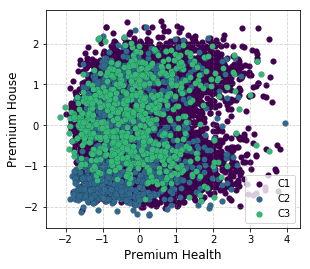

In [27]:
plot_clusters('premium_health', 'month_salary', 0,1, 'Premium Health', 'Premium House', 'clusters_health_house')

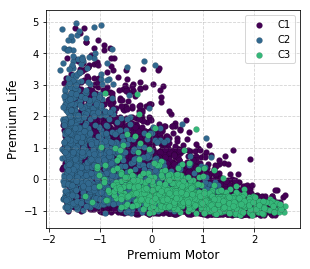

In [39]:
plot_clusters('premium_motor', 'premium_life', 2,3, 'Premium Motor', 'Premium Life', 'motor_life')

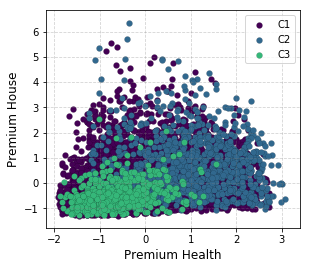

In [29]:
plot_clusters('premium_house', 'premium_work', 0,3, 'Premium Health', 'Premium House', 'clusters_health_house')

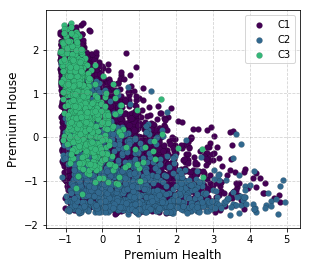

In [30]:
plot_clusters('premium_life', 'premium_motor', 0,1, 'Premium Health', 'Premium House', 'clusters_health_house')

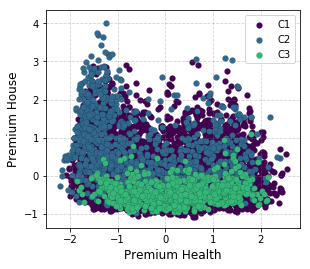

In [31]:
plot_clusters('month_salary', 'sum_premiums', 0,1, 'Premium Health', 'Premium House', 'clusters_health_house')

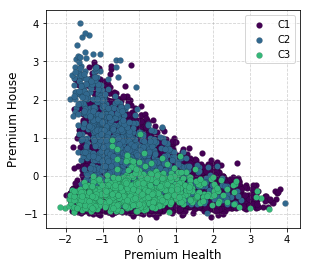

In [32]:
plot_clusters('premium_health', 'sum_premiums', 0,3, 'Premium Health', 'Premium House', 'clusters_health_house')

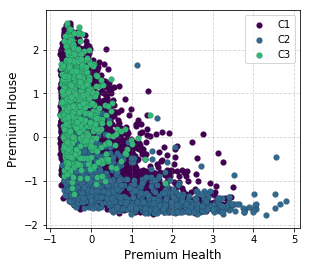

In [33]:
plot_clusters('engagement', 'premium_motor', 0,1, 'Premium Health', 'Premium House', 'clusters_health_house')

In [854]:
df_plot[df_plot['labels']==24].describe()

,claims_rate,month_salary,years_as_customer,education,sum_premiums,balance,engagement,premium_house,premium_health,premium_life,premium_work,premium_motor,labels_engagement,labels_consume
count,541.000000,541.000000,541.000000,5.410000e+02,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.0,541.0
mean,-0.043887,0.177256,0.023415,1.738185e+00,-0.362048,0.221840,-0.323561,-0.483628,-0.000621,-0.501338,-0.466214,0.606057,3.0,0.0
std,0.227319,0.898244,1.009772,1.600201e-14,0.249512,0.239926,0.320512,0.471109,0.991441,0.471730,0.498588,0.715537,0.0,0.0
min,-0.487319,-1.757325,-1.811450,1.738185e+00,-0.850095,-1.155919,-0.747371,-1.272586,-1.915339,-1.113440,-1.267123,-1.161103,3.0,0.0
25%,-0.269369,-0.596520,-0.903873,1.738185e+00,-0.537815,0.313919,-0.561736,-0.822094,-0.722668,-0.798747,-0.788567,0.056247,3.0,0.0
50%,0.014472,0.163974,0.154633,1.738185e+00,-0.408723,0.322472,-0.418660,-0.569010,-0.100900,-0.610148,-0.583175,0.659520,3.0,0.0
75%,0.170585,0.929483,0.911281,1.738185e+00,-0.225704,0.322472,-0.165305,-0.194926,0.637703,-0.326916,-0.296715,1.173427,3.0,0.0
max,0.421988,2.157509,1.819857,1.738185e+00,0.593401,0.322472,1.336501,1.187922,3.306248,2.726050,2.545534,2.171489,3.0,0.0


In [1242]:
df_engagement=df_engagement.drop('sum_premiums', axis=1)

In [1272]:
df_consume=df_consume.drop('premium_life', axis=1)